# Numerical Optimization and Large Scale Linear Algebra
## Assignment 3 - Classification of Handwritten Digits
### Instructor: P. Vassalos

**Student:** Phevos A. Margonis - f3352317

**Date:** 10/MAR/2024

---
This exercise involves constructing an algorithm for the classification of handwritten digits by computing the SVD of each class matrix, using the first few singular vectors as basis, and classifying test digits based on their representation in terms of these bases.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from tqdm import tqdm

np.random.seed(52346)

### Import Data

In [ ]:
# Train data
df = pd.read_excel('data.xlsx', sheet_name='azip', header=None, nrows=2000).T
df['labels'] = pd.read_excel('data.xlsx', sheet_name='dzip', header=None).T
df = df.sort_values(by='labels').reset_index(drop=True)

In [ ]:
# Test data
testDF = pd.read_excel('data.xlsx', sheet_name='testzip', header=None).T
testDF['labels'] = pd.read_excel('data.xlsx', sheet_name='dtest', header=None).T

In [55]:
# Refactor test data
X_test = testDF.iloc[:,:-1].values # Each row is a flattened image
y_test = testDF.labels.values

### Create class matrices

In [56]:
grouped = df.groupby('labels')
# Split class matrices
class_matrices = {}
for label, group_df in grouped:
    class_matrices[label] = group_df.iloc[:,:-1].values.T

### Plot some images

In [57]:
def ima2(A, ax=None):
    ''' Input an image VECTOR and get its plot '''
    A = np.squeeze(A)
    A = (A - np.min(A)) * (20 / (np.max(A) - np.min(A))) # Scale to interval [0,20]
    a1 = np.reshape(A, (16, 16)) # Reshape the vector as a matrix
    a1 = a1 - np.min(a1) # Set minimum value to 0
    a1 = (20 / np.max(a1)) * a1 # Normalize to [0, 20]

    # Standalone usage or in subplots
    # If ax is None, use plt.imshow; otherwise, use ax.imshow
    if ax is None:
        plt.imshow(a1, cmap='gray', vmin=0, vmax=20)
        # plt.colorbar()
        plt.show()
    else:
        cax = ax.imshow(a1, cmap='gray', vmin=0, vmax=20)
        # plt.colorbar(cax, ax=ax)

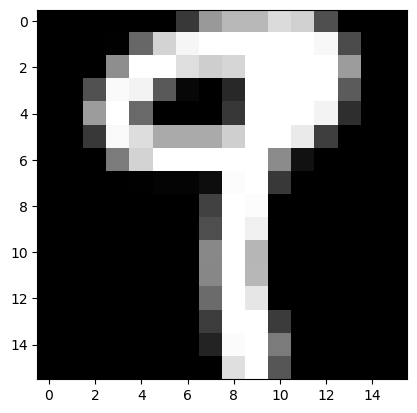

In [58]:
ima2(class_matrices[9][:,9])

C:\Users\Foivos\AppData\Local\Temp\ipykernel_13400\1735955333.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


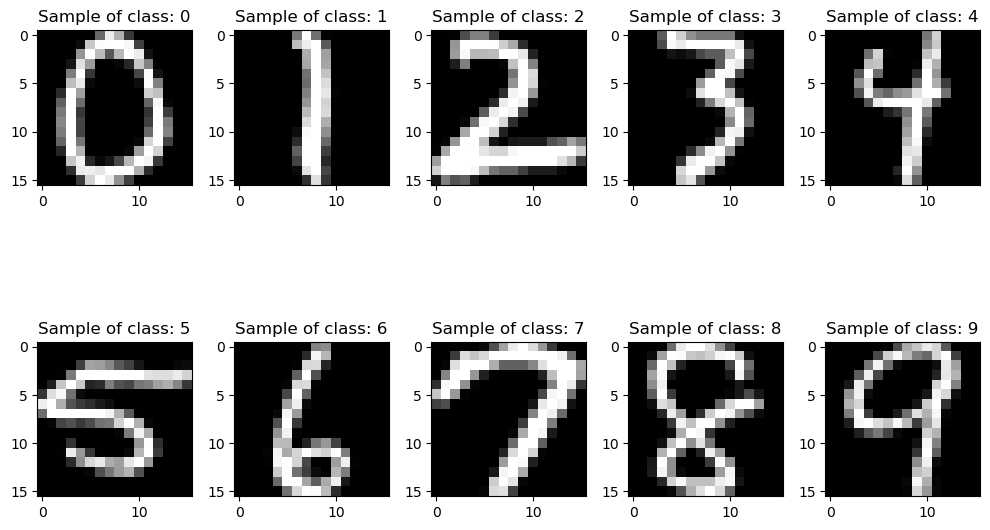

In [59]:
fig, axs = plt.subplots(2,5, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    ax.set_title(f'Sample of class: {i}')
    random_vector = class_matrices[i][:, np.random.randint(0, 100)]
    ima2(random_vector, ax=ax);
    plt.tight_layout();

## Main
---

In [60]:
def get_bases(matrices, bases: dict) -> dict:
    ''' Input class matrices and number of bases per class to use, and get the class bases matrices'''
    class_basis = {} # Store basis per class
    for label, matrix in matrices.items():
        U = np.linalg.svd(matrix, full_matrices=False)[0] # Perform SVD (U,s,Vt)
        class_basis[label] = U[:, :bases[label]] # Select the first few singular vectors as the basis (can be different per class)
    return class_basis

In [61]:
def calculate_residuals(image, class_basis) -> np.array:
    '''Calculate Residuals for each class using LS.'''
    residuals = np.empty(len(class_basis)) # Store residuals per class
    for label, basis in class_basis.items():
        coeffs = np.linalg.lstsq(basis, image, rcond=None)[0]
        projection = basis @ coeffs
        residual_vector = image - projection
        residuals[label] = np.linalg.norm(residual_vector)
    return residuals

In [74]:
def get_image_prediction(image, class_basis) -> int:
        ''' Classify the image as the class with the min residual. '''
        predicted_label = np.argmin(calculate_residuals(image, class_basis))
        return predicted_label

In [63]:
def my_predict(X , bases: dict) -> np.array:
    ''' Predict the labels for all the images'''

    # Compute the basis for each class
    class_basis = get_bases(matrices=class_matrices, bases=bases)

    # Predict the class of each test image
    y_pred = np.empty(X.shape[0])
    for i, image in tqdm(enumerate(X_test), desc='Predicting: ', total=len(X),leave=False):
        y_pred[i] = get_image_prediction(image, class_basis)
    return y_pred

## Compute accuracies per number of bases

Calculating accuracies graph:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating accuracies graph: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


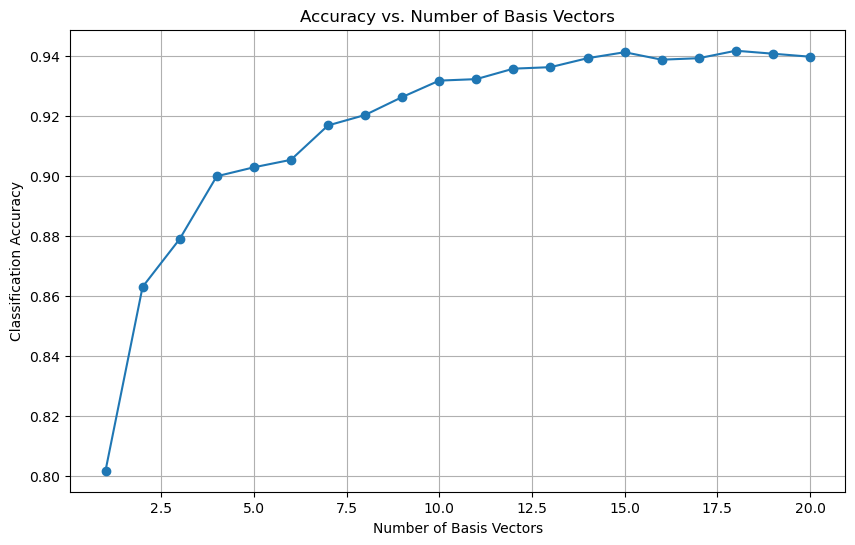

In [64]:
accuracy_per_basis_num = {} # Store accuracies per number of bases used
for Nbases in tqdm(range(1, 21), desc="Calculating accuracies graph: "):
    bases = {i:Nbases for i in range(10)} # Number of bases to use per class
    y_pred = my_predict(X=X_test, bases=bases)

    # Calculate overall accuracy
    accuracy_per_basis_num[Nbases] = accuracy_score(y_test,y_pred)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(list(accuracy_per_basis_num.keys()), list(accuracy_per_basis_num.values()), marker='o')
plt.xlabel('Number of Basis Vectors')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs. Number of Basis Vectors')
plt.grid(True)
plt.show()

### Continue with optimized number of bases
Accuracy trade-off stops at 15 bases

In [73]:
bases15 = {i:15 for i in range(10)}
y_pred = my_predict(X_test, bases15)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.9412057797708022


## Check ease of classification

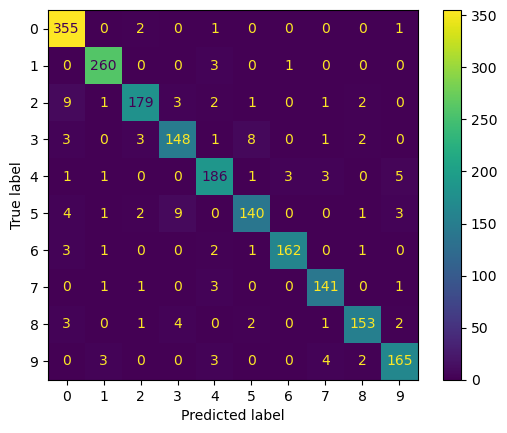

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=range(10),
                                        cmap='viridis',
                                        normalize=None);

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.97      0.98      0.98       264
           2       0.95      0.90      0.93       198
           3       0.90      0.89      0.90       166
           4       0.93      0.93      0.93       200
           5       0.92      0.88      0.89       160
           6       0.98      0.95      0.96       170
           7       0.93      0.96      0.95       147
           8       0.95      0.92      0.94       166
           9       0.93      0.93      0.93       177

    accuracy                           0.94      2007
   macro avg       0.94      0.93      0.94      2007
weighted avg       0.94      0.94      0.94      2007



The above metrics show that the hardest digits to classify are 5 and 3, since they have the lowest recall.

### Check some misclassified images

C:\Users\Foivos\AppData\Local\Temp\ipykernel_13400\4260012705.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


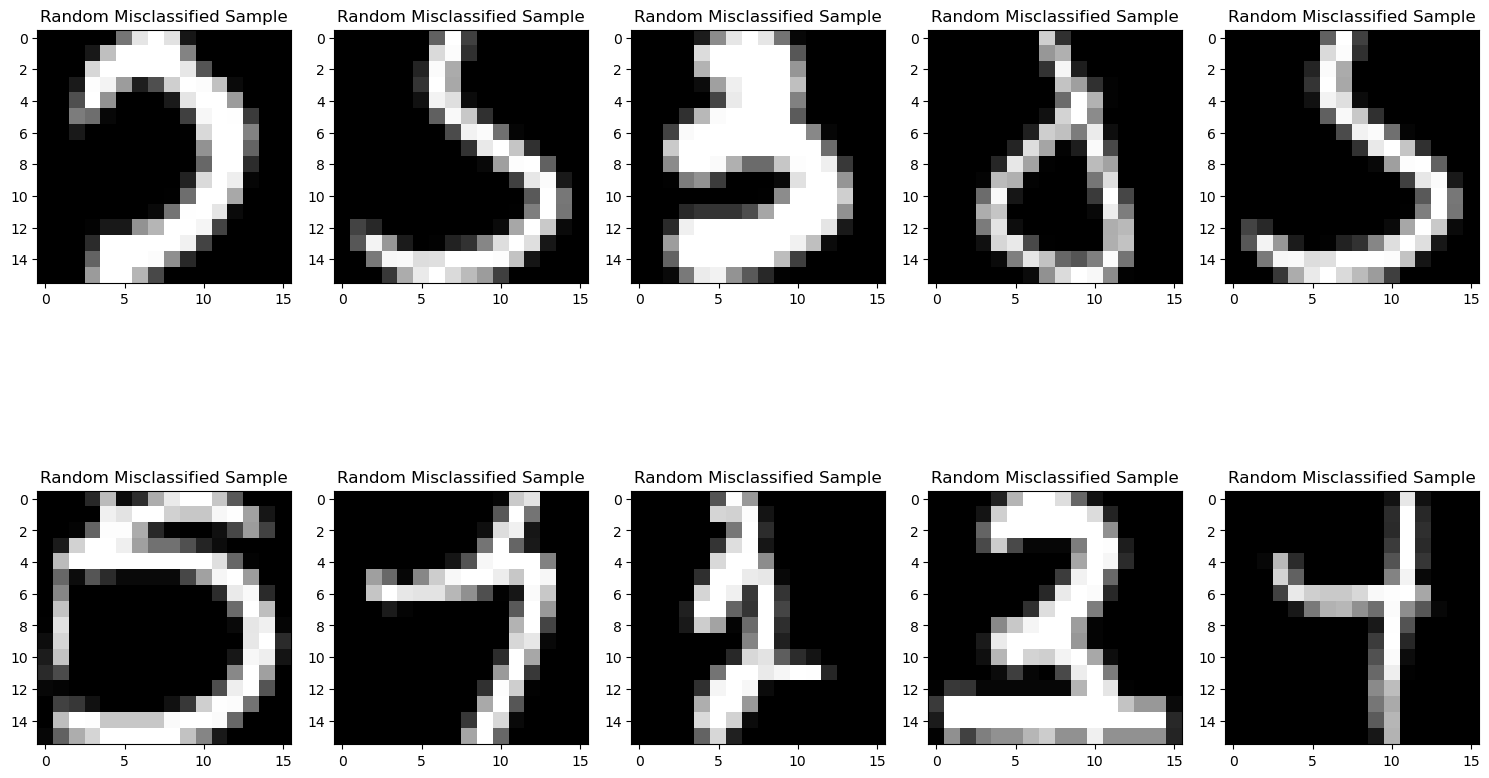

In [68]:
mask = np.where(y_test!=y_pred)[0] # Misclassified instances
# Plot random missclassifications
fig, axs = plt.subplots(2, 5, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.set_title('Random Misclassified Sample')
    random_vector = X_test[mask[np.random.randint(0, 100)], :]
    ima2(random_vector, ax=ax)
    plt.tight_layout()
plt.show()

## Optimize number of bases per class

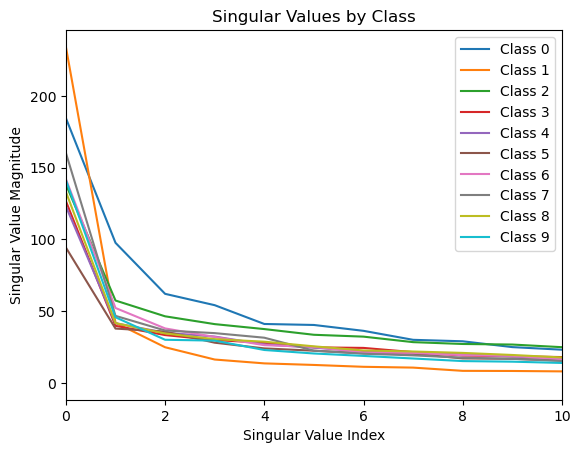

In [69]:
# Perform SVD for each class and plot singular values
for label, class_matrix in class_matrices.items():
    s = np.linalg.svd(class_matrix, full_matrices=False)[1]
    plt.plot(s, label=f'Class {label}')
plt.title('Singular Values by Class')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.xlim(0,10)
plt.legend()
plt.show()

The above graph shows that class 1 plateaus at a lower point than the rest classes.

### Optimized labels

In [72]:
number_to_beat = 0.9412057797708022

optimized_basis_numbers = {i:15 for i in range(10)}
optimized_basis_numbers[1] = 10
y_pred = my_predict(X_test, optimized_basis_numbers)

new_accuracy = accuracy_score(y_test, y_pred)
print(f"\nNew accuracy = {new_accuracy}")
print(f"Improvement: {new_accuracy-number_to_beat}")


New accuracy = 0.9417040358744395
Improvement: 0.0004982561036372957


Indeed the accuracy has improved by using a different number of bases for one class

## TWO-STAGE ALGORITHM WITH SVD
In order to save operation in the test phase we use the following approach.
In the first stage we compare the unknown digit only to the
first singular vector in each class. If for one class the residual is
significantly smaller than for the others, we classify as that class.

In [71]:
class_basis = get_bases(class_matrices, optimized_basis_numbers)
class_first_basis = {key: matrix[:, 0].reshape(-1,1) for key, matrix in class_basis.items()} # keep only the first basis of each class # Reshape from array to vector.

residual_threshold = 4 # Defined based on experimentation
y_pred_two_stage = np.empty(X_test.shape[0])
second_stage_count = 0

for i, image in tqdm(enumerate(X_test), total=len(X_test), desc="Predicting", leave=False):
    residuals = calculate_residuals(image, class_first_basis)
    # Find the two smallest residuals and calculate their difference
    two_smallest_residuals = np.partition(residuals, 1)[:2]  # Get the two smallest elements
    residual_difference = np.abs(two_smallest_residuals[1] - two_smallest_residuals[0])

    # Compare the difference with the threshold
    if residual_difference < residual_threshold:
        y_pred_two_stage[i] = np.argmin(residuals)
    else:
        # Stage 2: Proceed to the second stage as in the original algorithm
        second_stage_count += 1
        y_pred_two_stage[i] = get_image_prediction(image,class_basis)

print("\nAccuracy with two-stage algorithm:", accuracy_score(y_test, y_pred_two_stage))
print("Percentage of digits classified in the first stage:", (1 - second_stage_count / len(y_test)) * 100, "%")


Accuracy with two-stage algorithm: 0.8016940707523668
Percentage of digits classified in the first stage: 85.40109616342801 %


The experiments suggest that the accuracy is negatively impacted by this algorithm; however, it is twice as fast, thus making it a competitive alternative in situations where the matrices involved are extremely large.